In [61]:
using PyPlot
using DataFrames

In [62]:
#=
    Type of the point in the Cartesian coordinate system
=#
type Point{T <: Real}
    x::T
    y::T
    z::T
end

#=
    Type of the cluster with center and points,
    which belongs to its set
=#
type Cluster 
    center::Point
    points::Array{Point, 1}
end

In [63]:
#=
    Function that returns array of arrays
    of string values by reading of .csv file
=#
function datasetFromCSV(filename::String, customNastrings...)::DataFrame   
    readtable(filename, nastrings=["NA", "na", "n/a", "missing", customNastrings...])       
end    

#=
    Function that links columns of the dataset into 2-d matrix
=#
function datasetValues(dataset::DataFrame, columnNames...)::Matrix{Float64}    
    selectedData::DataFrame = dataset[:, map(Symbol, [columnNames...])] 
    values = Matrix{Float64}(nrow(selectedData), ncol(selectedData))
    # Excluding headers and rows' numbers
    for i::Int64 = 1 : nrow(selectedData)
        for j::Int64 = 1 : ncol(selectedData)
            values[i, j] = selectedData[i, j]
        end
    end
    values
end

#=
    Function that creates array of the points based on the chosen dataset,
    represented in 2-d matrix
=#
function determinePoints(datasetValues::Matrix{Float64})::Array{Point, 1}
    len::Int64 = size(datasetValues, 1)
    points = Array{Point, 1}(len)  
    for i::Int64 = 1 : len
        point = Point(datasetValues[i, 1], datasetValues[i, 2], datasetValues[i, 3])      
        points[i] = point      
    end  
    points
end

#=
    Function that creates array of points' projections
    based on the selected axis ("x", "y", "z")
=#
function pointsProjections(points::Array{Point, 1}, axis::String)::Array{Float64, 1}
    coords = Array{Float64, 1}(0)
    for p::Point in points
        if(lowercase(axis) == "x")
            push!(coords, p.x)
        elseif(lowercase(axis) == "y")
            push!(coords, p.y)
        elseif(lowercase(axis) == "z")
            push!(coords, p.z)
        else    
            push!(coords, 0.0)      
        end
    end
    coords
end

#=
    Function that returns point by random index
    from the array of points   
=#
function randomPoint(points::Array{Point, 1})::Point
    index::Int64 = rand(1: size(points, 1))
    points[index];
end

#=
    Function that creates initial clusters   
=#
function defineInitialClusters(clustersCount::Int64, points::Array{Point, 1})::Array{Cluster, 1}
    clusters = Array{Cluster, 1}(clustersCount)    
    for i = 1 : clustersCount
        center = randomPoint(points)
        cluster = Cluster(center, [center])
        clusters[i] = cluster
    end
    clusters
end

#=
    Function that returns distance between two points 
=#
function distance(point1::Point, point2::Point)::Float64   
    norm([point1.x, point1.y, point1.z] - [point2.x, point2.y, point2.z])    
end

#=
    Function that returns distances' matrix based on distances between
    clusters' centers and all the points
=#
function distanceMatrix(points::Array{Point, 1}, clusters::Array{Cluster, 1})::Matrix{Float64}
    distanceMatrix = Matrix{Float64}(length(points), length(clusters))
    for i::Int64 = 1 : length(points)
        for j::Int64 = 1 : length(clusters)
            distanceMatrix[i, j] = distance(points[i], clusters[j].center)
        end
    end    
    distanceMatrix
end

#=
    Function that compares two points by their coordinates  
=#
function comparePointsCoordinates(point1::Point, point2::Point)
   point1.x == point2.x && point1.y == point2.y && point1.z == point2.z
end

#=
    Function that returns new center of the cluster as the center of mass   
=#
function centerMassOfCluster(cluster::Cluster)::Point   
    x::Float64 = reduce(+, pointsProjections(cluster.points, "x")) / length(cluster.points)
    y::Float64 = reduce(+, pointsProjections(cluster.points, "y")) / length(cluster.points)
    z::Float64 = reduce(+, pointsProjections(cluster.points, "z")) / length(cluster.points)    
    Point(x, y, z)    
end

#=
    Function for displaying clusters
=#
function displayCluster(clusters::Array{Cluster, 1})
    # Display clustering iteration
    for i::Int64 = 1 : length(clusters)
        println("CLUSTER $i:")
        println(clusters[i])
        println("SIZE: $(length(clusters[i].points))")
    end
end

#=
    Function that makes one iteration of the clustering 
=#
function kmeansIteration(clusters::Array{Cluster, 1}, points::Array{Point, 1})::Bool 
    status::Bool  = false;     
    dtMatrix::Matrix{Float64} = distanceMatrix(points, clusters)      
    for i::Int64 = 1 : size(dtMatrix, 1)
        minIndex::Int64 = indmin(dtMatrix[i, 1 : size(dtMatrix, 2)])  
        if(!(points[i] in clusters[minIndex].points))            
            push!(clusters[minIndex].points, points[i])    
        end
        for j::Int64 = 1 : size(dtMatrix, 2)
            if(j != minIndex && (points[i] in clusters[minIndex].points))                                 
                clusters[j].points = filter!(pnt -> pnt != points[i], clusters[j].points)                     
            end
        end      
    end
    for cl::Cluster in clusters
        newCenter::Point = centerMassOfCluster(cl)
        if(comparePointsCoordinates(cl.center, newCenter))
           status = true; 
        else
           cl.center = newCenter
        end
    end
    # displayClustersInfo(clusters)
    status   
end

#=
    Function that makes the whole clustering by the k-means algorithm
=#
function kmeans(clustersCount::Int64, datasetValues::Matrix{Float64})::Array{Cluster, 1}
    iteration = 0;
    # Creating points based on dataset
    points::Array{Point, 1} = determinePoints(datasetValues)
    # Creating inital clusters
    clusters::Array{Cluster, 1} = defineInitialClusters(clustersCount, points)
    # Do clustering until clusters' centers will change
    while(!kmeansIteration(clusters, points))  
        iteration += 1
    end
    println("Iterations: $iteration") 
    return clusters
end

#=
    Function that draws chart based on the sets of the clusters' points
=#
function drawClustersChart(clusters::Array{Cluster, 1})    
    for cluster::Cluster in clusters
        plot(pointsProjections(cluster.points, "x"), 
            pointsProjections(cluster.points, "y"), 
            pointsProjections(cluster.points, "z"), "o")       
    end    
end

#=
    Function that draws chart based on all the points
=#
function drawGeneralChart(points::Array{Point, 1})
    gca(projection="3d")
    axis("auto")
    xlabel("X")
    ylabel("Y")
    zlabel("Z")
    plot(pointsProjections(points, "x"), 
            pointsProjections(points, "y"), 
            pointsProjections(points, "z"), "o")    
end

drawGeneralChart (generic function with 2 methods)

In [64]:
# Reading data from .csv file
dataset = datasetFromCSV("creditcard.csv")

# Getting values for dataset by column names
values = datasetValues(dataset, "V1", "V3", "V6")

# Creating points according to the following dataset
points = determinePoints(values)

202-element Array{Point,1}:
 Point{Float64}(-1.35981, 2.53635, 0.462388)   
 Point{Float64}(1.19186, 0.16648, -0.0823608)  
 Point{Float64}(-1.35835, 1.77321, 1.8005)     
 Point{Float64}(-0.966272, 1.79299, 1.2472)    
 Point{Float64}(-1.15823, 1.54872, 0.0959215)  
 Point{Float64}(-0.425966, 1.14111, -0.0297276)
 Point{Float64}(1.22966, 0.0453708, 0.272708)  
 Point{Float64}(-0.644269, 1.07438, 0.428118)  
 Point{Float64}(-0.894286, -0.113192, 3.72182) 
 Point{Float64}(-0.338262, 1.04437, -0.246761) 
 Point{Float64}(1.44904, 0.91386, -0.629152)   
 Point{Float64}(0.384978, -0.8743, 3.31703)    
 Point{Float64}(1.25, 0.38393, -0.75323)       
 ⋮                                             
 Point{Float64}(-2.80706, 2.97478, 3.21783)    
 Point{Float64}(0.853908, 0.823846, 0.528598)  
 Point{Float64}(-0.72491, 1.73955, 2.42207)    
 Point{Float64}(1.35649, -1.237, 3.10391)      
 Point{Float64}(-0.549716, 1.59795, 0.0323759) 
 Point{Float64}(1.23949, 0.155058, -1.23561)   
 Point{Float

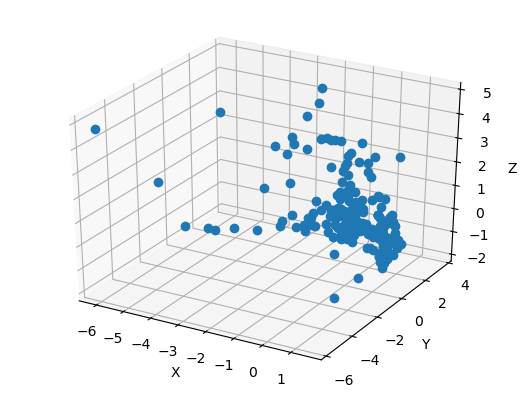

1-element Array{PyCall.PyObject,1}:
 PyObject <mpl_toolkits.mplot3d.art3d.Line3D object at 0x000000002996E748>

In [65]:
# Build chart based on all points
drawGeneralChart(points)

In [66]:
# Defining count of the clusters
clustersCount = 6

# Creating inital clusters
clusters = defineInitialClusters(clustersCount, points)

6-element Array{Cluster,1}:
 Cluster(Point{Float64}(-0.658305, 2.03746, -0.350857), Point[Point{Float64}(-0.658305, 2.03746, -0.350857)])
 Cluster(Point{Float64}(1.23905, 0.086472, 0.325596), Point[Point{Float64}(1.23905, 0.086472, 0.325596)])    
 Cluster(Point{Float64}(-1.16942, 1.4068, 0.122035), Point[Point{Float64}(-1.16942, 1.4068, 0.122035)])      
 Cluster(Point{Float64}(-1.79341, 0.979514, -0.199546), Point[Point{Float64}(-1.79341, 0.979514, -0.199546)])
 Cluster(Point{Float64}(1.32271, 0.434555, -0.831083), Point[Point{Float64}(1.32271, 0.434555, -0.831083)])  
 Cluster(Point{Float64}(1.14755, 0.504579, -0.61112), Point[Point{Float64}(1.14755, 0.504579, -0.61112)])    

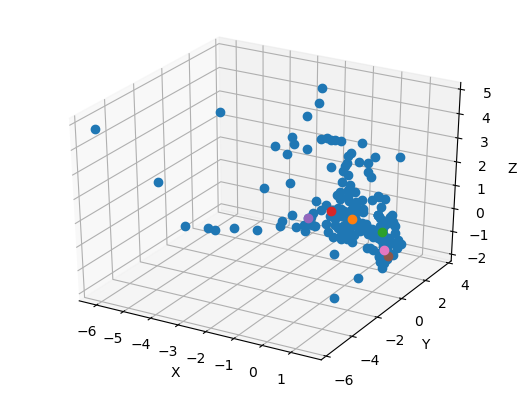

In [67]:
# Detecting clusters based on their random centers
drawGeneralChart(points)
drawClustersChart(clusters)

In [68]:
# First iteration results
kmeansIteration(clusters, points)

false

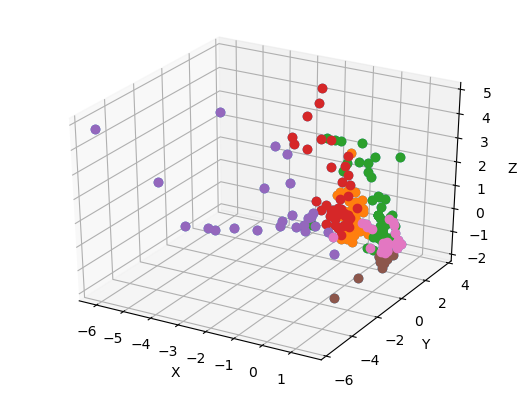

In [69]:
# Chart by the first iteration results
drawGeneralChart(points)
drawClustersChart(clusters)

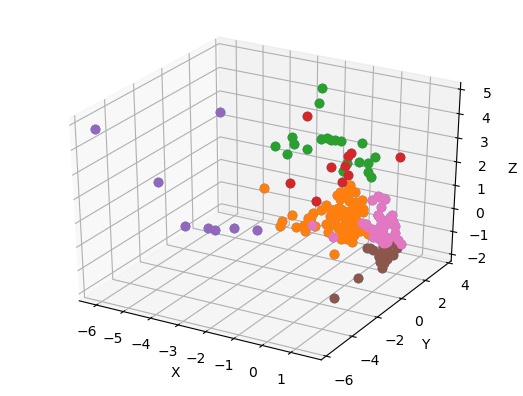

`Iterations: 4`


In [70]:
# Do clustering until clusters' centers will change
counter = 1;
while(!kmeansIteration(clusters, points))  
    counter += 1
end
println(`Iterations: $counter`)

# Chart based on last iteration
drawGeneralChart(points)
drawClustersChart(clusters)